In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
from pathlib import Path

C:\Users\PAVAN KALYAN\AppData\Local\Temp\ipykernel_18188\2035490687.py:24: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [8]:
#!pip install --upgrade tensorflow-gpu --user

In [2]:
def show_image_samples(gen):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [3]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [4]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables 
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0        
        self.best_epoch=1   # epoch with the lowest loss        
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it         
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored 
        
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting train with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print_in_color (msg, (244, 252, 3), (55,65,80)) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')       
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch              
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt  or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80)) 

In [5]:
def Data_organization(no_dir,yes_dir,pred_dir,train_size):

    # read all images to each list
    no_data_paths_list = list(Path(no_dir).glob("*.jpg"))
    yes_data_paths_list = list(Path(yes_dir).glob("*.jpg"))
    pred_data_paths_list = list(Path(pred_dir).glob("*.jpg"))

    # concat lists
    data_paths_list = []
    data_labels_list = []
    pred_labels_list = []
    for p in no_data_paths_list:
        data_paths_list.append(p)
        data_labels_list.append("no")
    for p in yes_data_paths_list:
        data_paths_list.append(p)
        data_labels_list.append("yes")
    for p in pred_data_paths_list:
        pred_labels_list.append("pred")

    # Data data_frame
    data_paths_series = pd.Series(data_paths_list, name="Images").astype(str)
    data_labels_Series = pd.Series(data_labels_list, name="TUMOR_Category")
    Main = pd.concat([data_paths_series, data_labels_Series], axis=1)

    # pred data_frame
    pred_paths_series = pd.Series(pred_data_paths_list, name="Images").astype(str)
    pred_labels_Series = pd.Series(pred_labels_list, name="TUMOR_Category")
    Pred = pd.concat([pred_paths_series, pred_labels_Series], axis=1)

    # Suffule data
    Main = Main.sample(frac=1).reset_index(drop=True)
    
    #split Data to train & test
    Train , Test_Val = train_test_split(Main , train_size = train_size , random_state=42)
    Test , Val = train_test_split(Test_Val , train_size = 0.5 , random_state=42)


    return Train , Test , Val , Pred

In [6]:
def Data_Generate(Train_data , Test_data ,Val_data, Pred_data):

    def scalar(img):
        return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required

    train_generator = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
    others_generator = ImageDataGenerator(preprocessing_function=scalar)

    train_gen = train_generator .flow_from_dataframe(dataframe=Train_data,x_col="Images",y_col="TUMOR_Category",color_mode="rgb",class_mode="categorical",shuffle=True,batch_size=20,target_size=(300, 300))

    valid_gen = others_generator.flow_from_dataframe(dataframe=Val_data,x_col="Images",y_col="TUMOR_Category",color_mode="rgb",class_mode="categorical",shuffle=True,batch_size=20,target_size=(300, 300))

    test_gen = others_generator.flow_from_dataframe(dataframe=Test_data,x_col="Images",y_col="TUMOR_Category",color_mode="rgb",class_mode="categorical",shuffle=False,batch_size=75,target_size=(300, 300))

    pred_gen = others_generator.flow_from_dataframe(dataframe=Pred_data,x_col="Images",y_col="TUMOR_Category",color_mode="rgb",class_mode="categorical",shuffle=False,batch_size=20,target_size=(300, 300))

    classes = list(train_gen.class_indices.keys())
    class_count = len(classes)
    train_steps = int(np.ceil(len(train_gen.labels) / 20))

    return train_gen , test_gen , valid_gen , pred_gen , classes , class_count , train_steps


In [7]:
def saver(save_path, model, model_name):
    # first save the model
    save_id=str (model_name + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('Model H5 file was saved as ' + model_save_loc, (0,255,0),(55,65,80)) 
    return model_save_loc

In [8]:
def Predict_with_model_path(Model_path , Data_gen , df , classes , show_res , labeled):
  
  show = show_res
  label = labeled

  classes_pred = classes
  model = load_model(Model_path)
  prediction = model.predict(Data_gen)
  df = df

  prediction_results = []
  prediction_real = []

  for i in prediction :
    prediction_results.append(classes_pred[np.argmax(i)])

  for i in range(0,len(df)):
    prediction_real.append(df["TUMOR_Category"].iloc[i])

  if show :

    if label :
      counter = 0
      for i in range(0,len(df)):
        if prediction_real[i] != prediction_results[i]:
          counter +=1

      print_in_color(f"Difference between prediction results and Real Labels are : {counter} from {len(prediction_real)} ",(0,255,0),(55,65,80))
          
    
    fig, axes = plt.subplots(nrows=5,ncols=5,figsize=(20, 20),subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flat):
      ax.imshow(plt.imread(df["Images"].iloc[i]))
      if label:
        ax.set_title( f"PRED:{prediction_results[i]} -- REAL: {prediction_real[i]}") 
      else :
        ax.set_title(f"PREDICTION:{prediction_results[i]}") 

      
    plt.tight_layout()
    plt.show()

  return prediction,prediction_results
        

In [9]:
def Predict_with_Model(Model , Data_gen , df , classes , show_res , labeled):
  
  show = show_res
  label = labeled

  classes_pred = classes
  model = Model
  prediction = model.predict(Data_gen)
  df = df

  prediction_results = []
  prediction_real = []

  for i in prediction :
    prediction_results.append(classes_pred[np.argmax(i)])

  for i in range(0,len(df)):
    prediction_real.append(df["TUMOR_Category"].iloc[i])

  if show :

    if label :
      counter = 0
      for i in range(0,len(df)):
        if prediction_real[i] != prediction_results[i]:
          counter +=1

      print_in_color(f"Difference between prediction results and Real Labels are : {counter} from {len(prediction_real)} ",(0,255,0),(55,65,80))
          
    
    fig, axes = plt.subplots(nrows=5,ncols=5,figsize=(20, 20),subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flat):
      ax.imshow(plt.imread(df["Images"].iloc[i]))
      if label:
        ax.set_title( f"PRED:{prediction_results[i]} -- REAL: {prediction_real[i]}") 
      else :
        ax.set_title(f"PREDICTION:{prediction_results[i]}") 

      
    plt.tight_layout()
    plt.show()

  return prediction,prediction_results

In [10]:
def check_model_with_graph(tr_data):

    val_losses = tr_data.history["val_loss"]
    val_acc = tr_data.history["val_accuracy"]
    acc = tr_data.history["accuracy"]
    losses = tr_data.history["loss"]
    epochs = range(1, len(val_losses) + 1)
    
    plt.style.use('fivethirtyeight')
    
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))

    axes[0].plot(epochs, losses, "r", label="LOSS")
    axes[0].plot(epochs, val_losses, "g", label="LOSS VALIDATION")
    axes[0].set_title("LOSS & LOSS VAL")
    axes[0].set_xlabel("EPOCH")
    axes[0].set_ylabel("LOSS")
    axes[0].legend()

    
    axes[1].plot(epochs, acc, "r", label="ACCURACY")
    axes[1].plot(epochs, val_acc, "g", label="ACCURACY VALIDATION")
    axes[1].set_title("ACCURACY & ACCURACY VAL")
    axes[1].set_xlabel("EPOCH")
    axes[1].set_ylabel("ACCURACY")
    axes[1].legend()
    
    plt.show()

In [11]:
def print_confusion_matrix(true_labels_list , pred_labels_list , class_names):
    
    figsize = (10,7)
    fontsize=14
    
    cm = confusion_matrix(true_labels_list,pred_labels_list)
    cr=classification_report(true_labels_list,pred_labels_list)
    
    
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names,)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="Greens")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')
    plt.title("Confusion Matrix")
    plt.show()
    print("\n\n\n")
    print_in_color("Classification Report:-",(255,0,0),(255,255,0))
    print("\n", cr)

In [12]:
no_dir = r"../input/brain-tumor-detection/no"
yes_dir = r"../input/brain-tumor-detection/yes"
pred_dir = r"../input/brain-tumor-detection/pred"
train_size = 0.8
Train_data , Test_data ,Val_data, Pred_data = Data_organization(no_dir,yes_dir,pred_dir,train_size)

In [13]:
train_gen , test_gen , valid_gen , pred_gen , classes , class_count , train_steps = Data_Generate(Train_data , Test_data ,Val_data, Pred_data)

Found 2400 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 1 classes.


In [14]:
model_name = 'EfficientNetB4'
base_model = tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet", input_shape=(300, 300, 3),pooling='max')
x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.45, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

71696384/71686520 [==============================] - 1s 0us/step


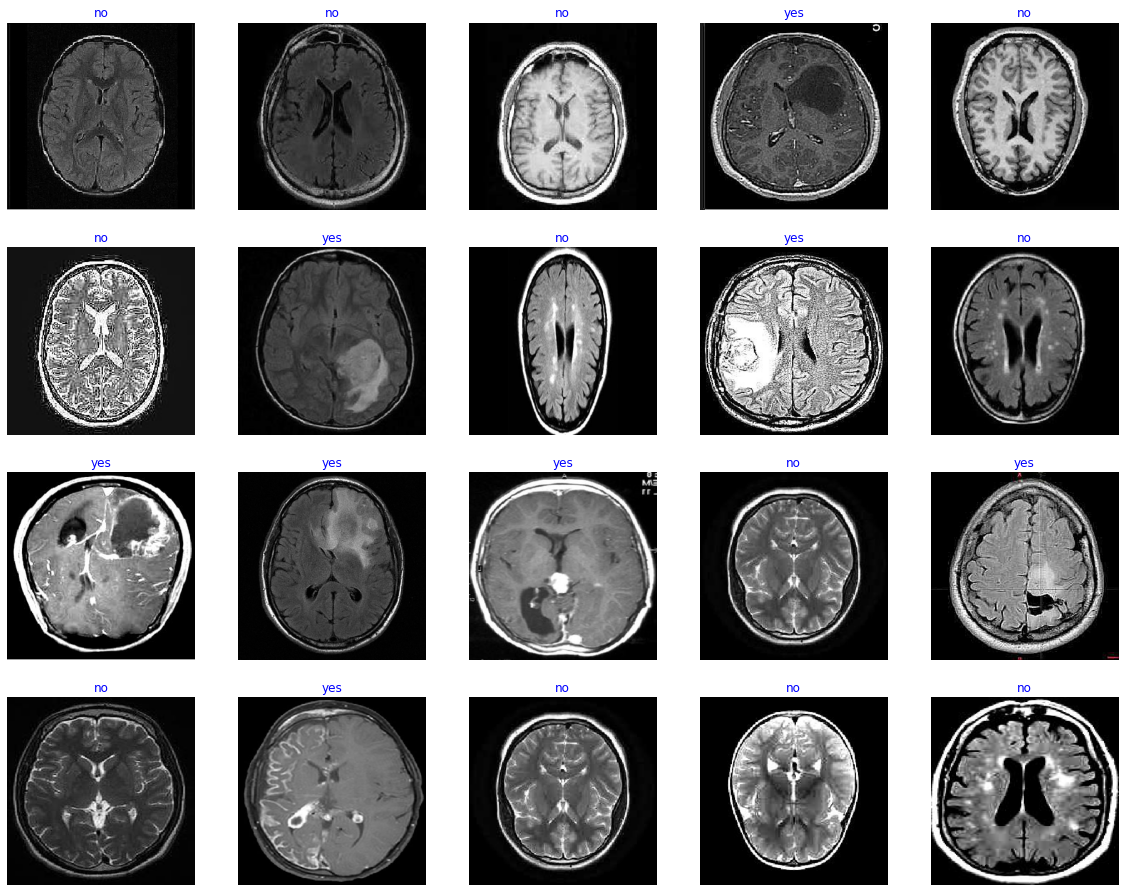

In [15]:
show_image_samples(train_gen)

In [17]:
##### epochs = 40
patience = 1  # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3  # number of epochs to wait before stopping training if monitored value does not improve
threshold = .9  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = .5  # factor to reduce lr by
dwell = True  # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze = False  # if true free weights of  the base model
ask_epoch = 5  # number of epochs to run before asking if you want to halt training
batches = train_steps
callbacks = [
LRA(model=model, base_model=base_model, patience=patience, stop_patience=stop_patience, threshold=threshold,factor=factor, dwell=dwell, batches=batches, initial_epoch=0, epochs=epochs, ask_epoch=ask_epoch)]
history = model.fit(x=train_gen, epochs=epochs, verbose=0, callbacks=callbacks, validation_data=valid_gen,validation_steps=None, shuffle=False, initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     1.032   99.875   0.88767  99.000   0.00100  0.00100  val_loss     0.00    77.68  

 2 /40     0.763   99.625   0.64023  99.667   0.00100  0.00100  val_loss    27.88    78.32  

 3 /40     0.558   99.917   0.47695  99.000   0.00100  0.00100  val_loss    25.50    77.94  

 4 /40     0.417   99.917   0.35606  99.000   0.00100  0.00100  val_loss    25.35    77.87  

 5 /40     0.320   99.792   0.28449  99.333   0.00100  0.00100  val_loss    20.10    77.22  

enter H to halt  or an integer for number of epochs to run then ask again



 5


 training will continue until epoch 10

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 6 /40     0.250   99.833   0.22476  99.667   0.00100  0.00100  val_loss    21.00    77.50  

 7 /40     0.202   99.958   0.18671  99.333   0.00100  0.00100  val_loss    16.93    78.12  

 8 /40     0.180   99.542   0.19293  99.000   0.00100  0.00050  val_loss    -3.33    77.89  

 9 /40     0.174   99.917   0.17306  99.000   0.00050  0.00050  val_loss     7.31    78.34  

10 /40     0.159   99.833   0.15236  99.333   0.00050  0.00050  val_loss    11.96    78.08  

enter H to halt  or an integer for number of epochs to run then ask again



 H


training has been halted at epoch 10 due to user input

Training is completed - model is set with weights from epoch 10 

training elapsed time was 0.0 hours, 13.0 minutes, 12.23 seconds)



In [18]:
SavedModelPath = saver("./", model, "Model_2F")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model H5 file was saved as ./Model_2F.h5



Difference between prediction results and Real Labels are : 4 from 300 



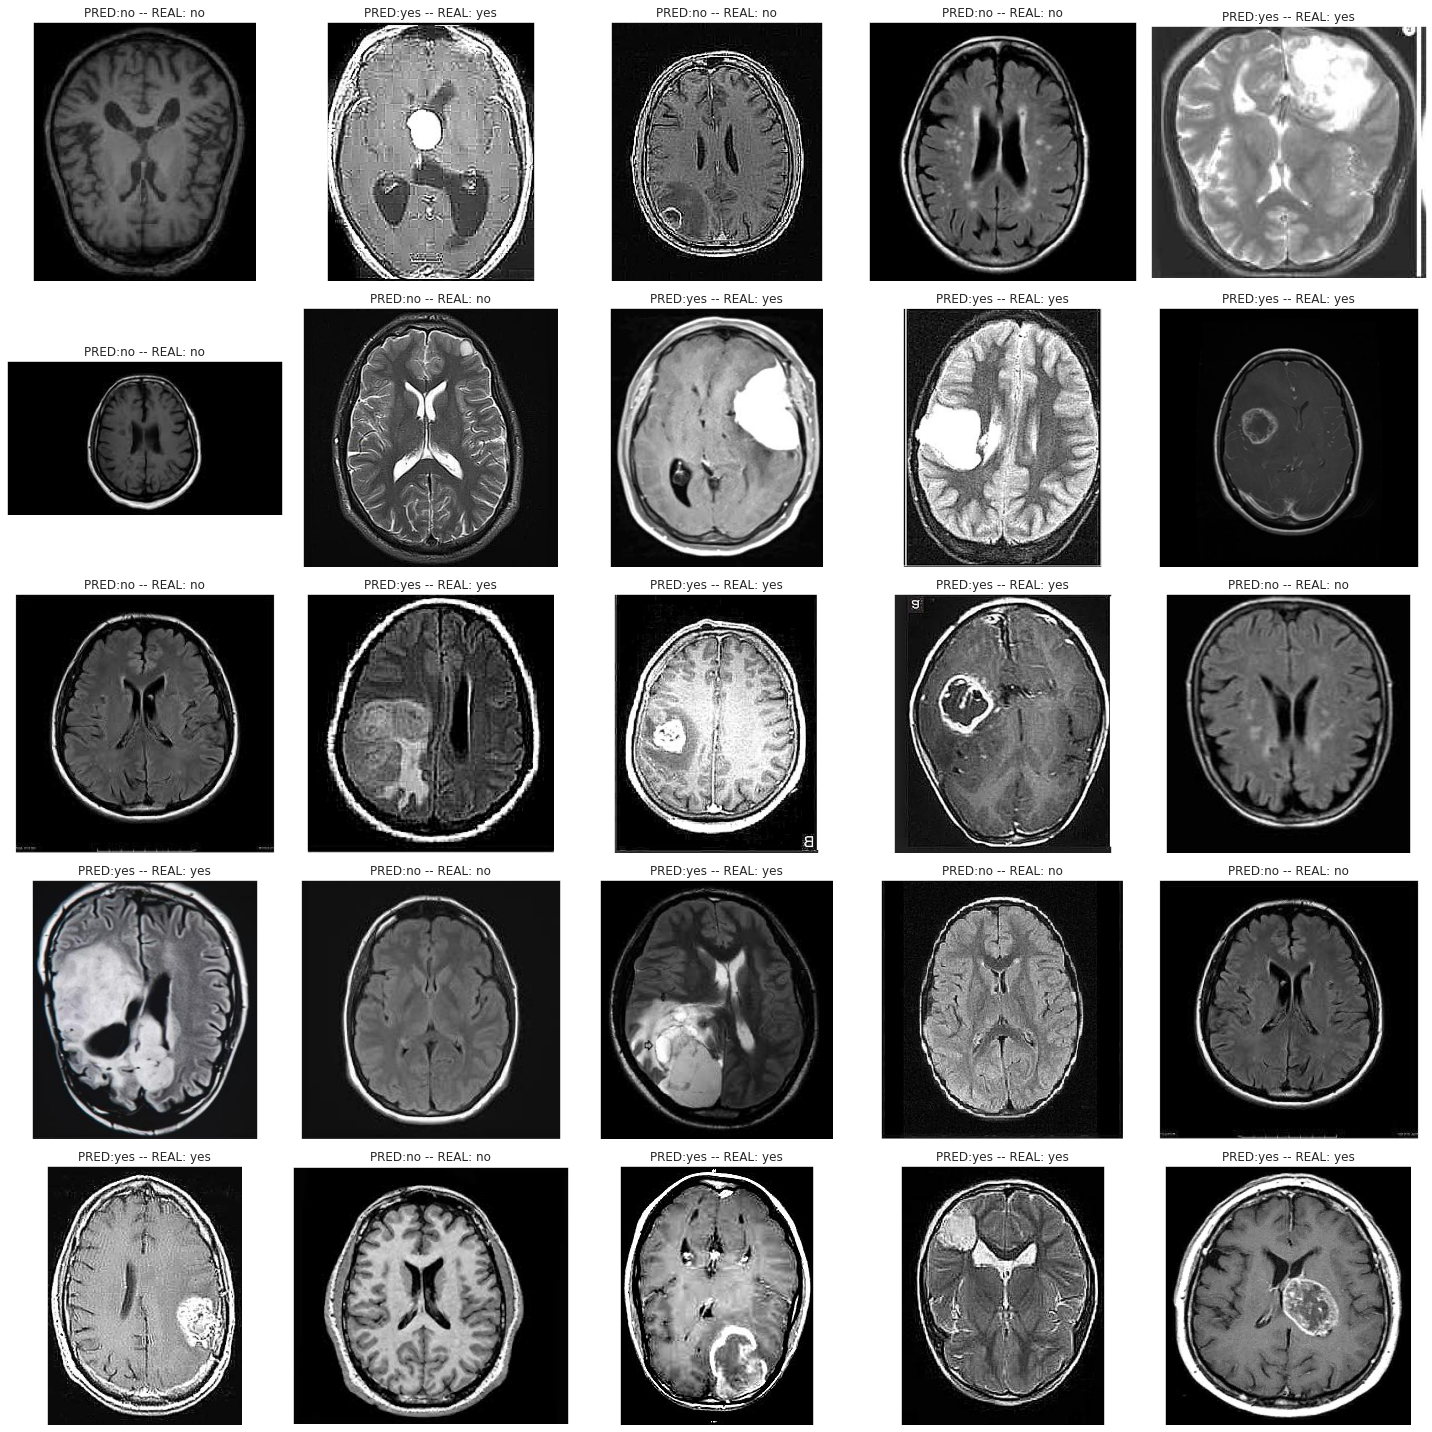

In [19]:
test_prediction , test_prediction_results = Predict_with_model_path(SavedModelPath , test_gen , Test_data , classes , True , True)

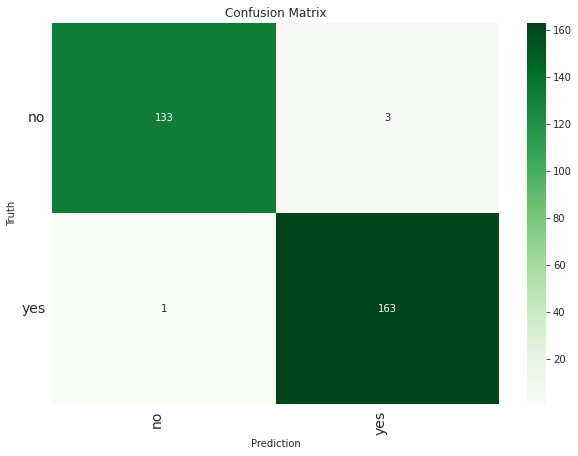





Classification Report:-


               precision    recall  f1-score   support

          no       0.99      0.98      0.99       136
         yes       0.98      0.99      0.99       164

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [20]:
print_confusion_matrix(Test_data['TUMOR_Category'].tolist(),test_prediction_results , classes)

Difference between prediction results and Real Labels are : 1 from 300 



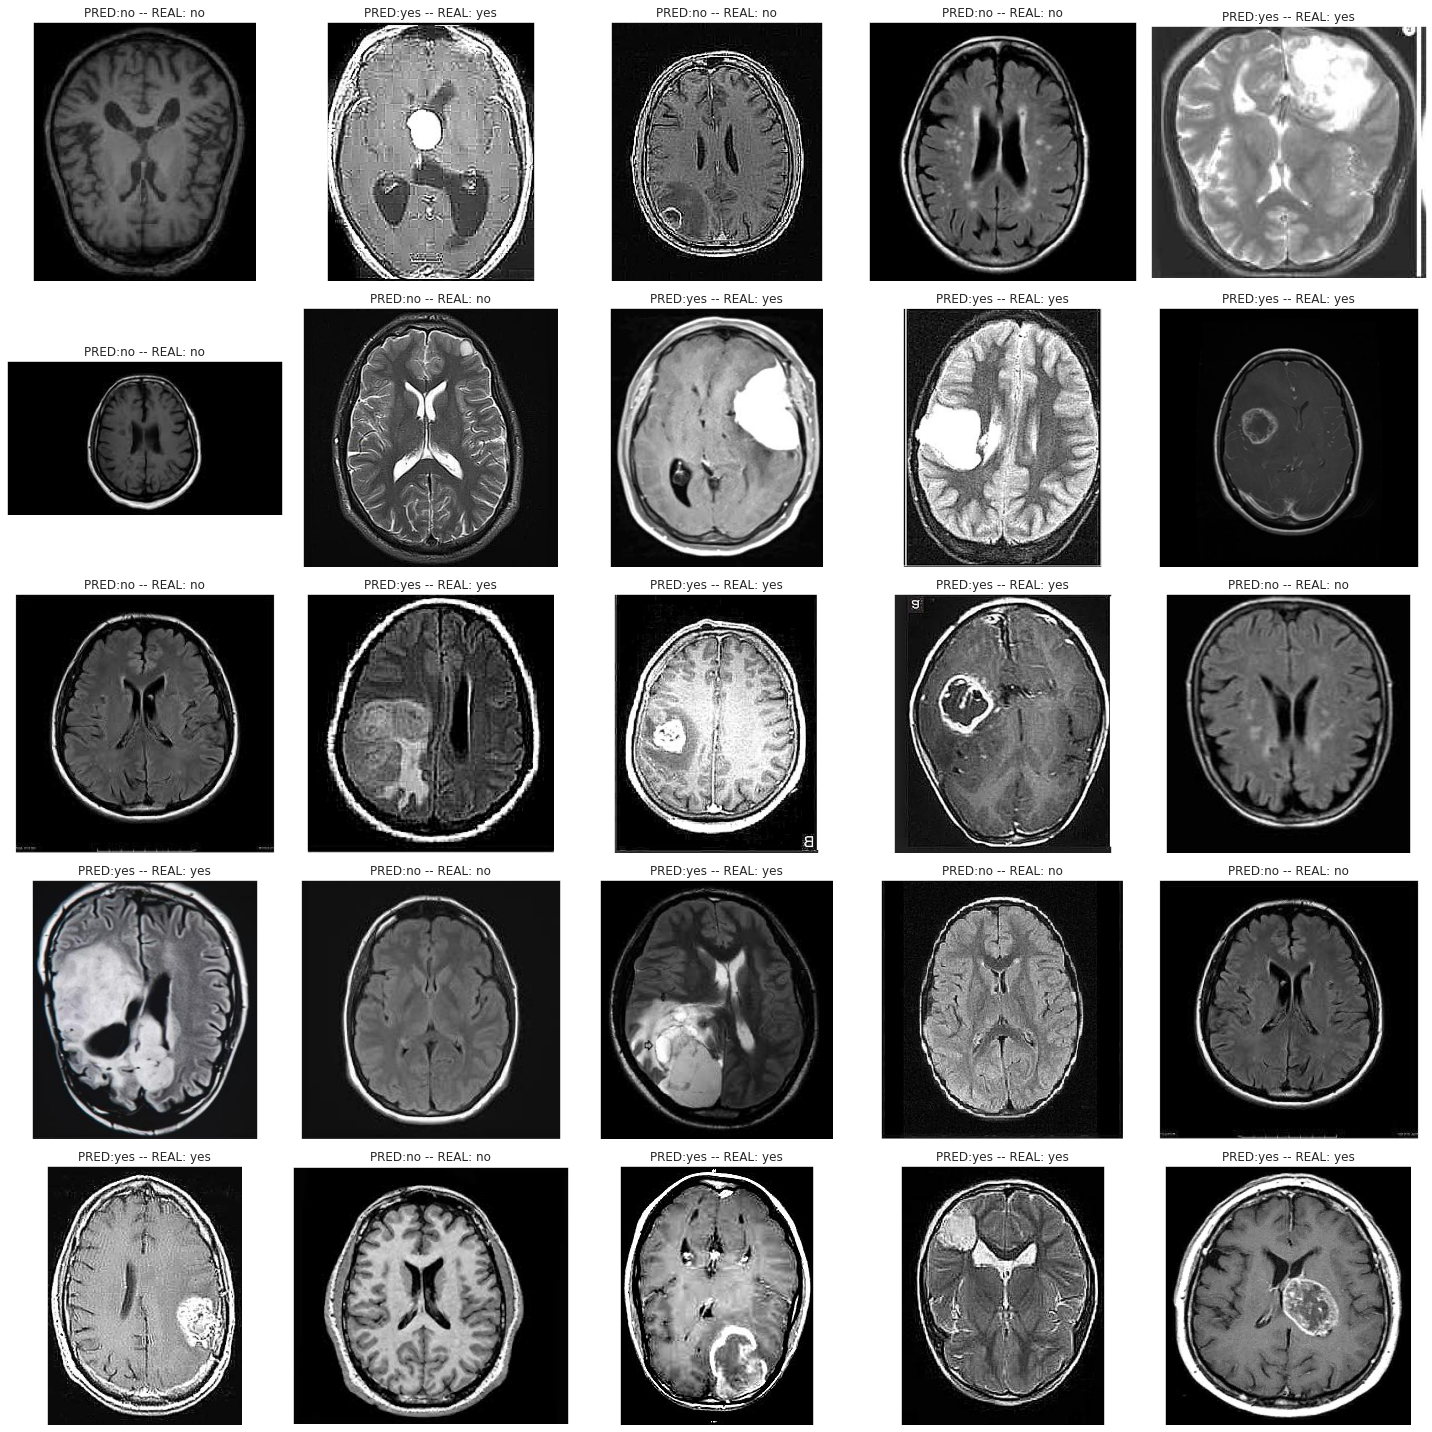

In [21]:
test_prediction1 , test_prediction_results1 = Predict_with_Model(model , test_gen , Test_data , classes , True , True)

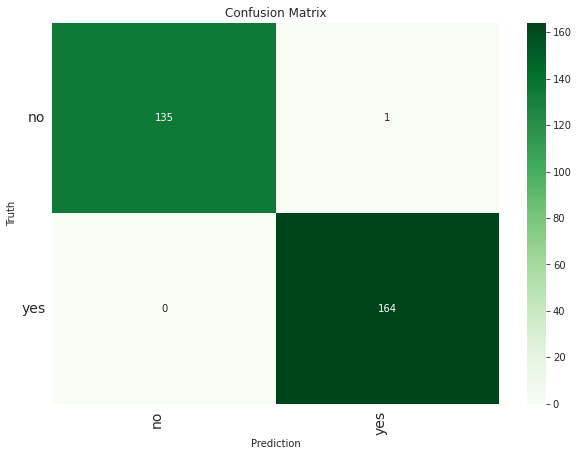





Classification Report:-


               precision    recall  f1-score   support

          no       1.00      0.99      1.00       136
         yes       0.99      1.00      1.00       164

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [22]:
print_confusion_matrix(Test_data['TUMOR_Category'].tolist(),test_prediction_results1 , classes)

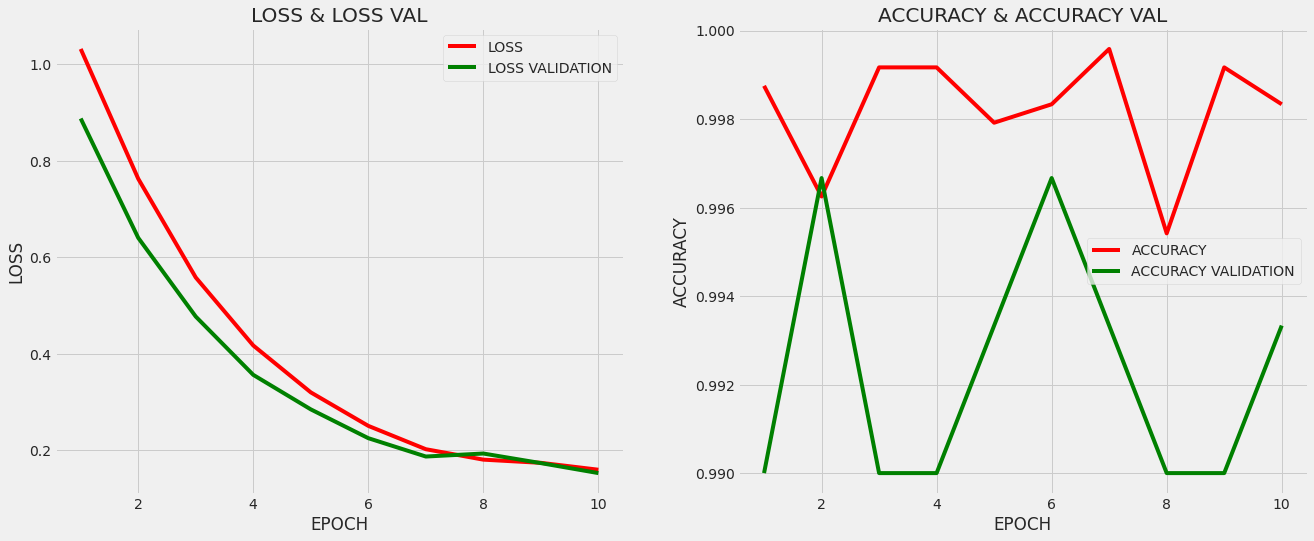

In [23]:
check_model_with_graph(history)